# ***THIS NOTEBOOK PLOTS THE PRECISION OF THE MINIMIZATION WITH RESPECT TO THE CPU TIME***
---
---
---
---
---

# IMPORTS AND GLOBAL VARIABLES

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math
import keras
from keras import layers, models, optimizers
from keras.callbacks import History
from scipy import integrate
from scipy import interpolate
from scipy.stats import norm
import time

hbar = 1
omega = 1
m = 1
a = -5.
b = 5.

Using TensorFlow backend.


# DATA GENERATION

In [ ]:
#################
#SECTION : FUNCTION DEFINITION
#################

#W.F. stands for "wave function"

def energy_compute (abscissa,psi):
  #interpolations
  tck_true = interpolate.splrep(abscissa, psi, k=3, s=0)                                         #W.F.
  tck_true_carre = interpolate.splrep(abscissa, psi*psi, k=3, s=0)                               #W.F. squared
  tck_true_x = interpolate.splrep(abscissa, abscissa*abscissa*psi*psi, k=3, s=0)                 #W.F. squared*x^2
  der_true = interpolate.splev(abscissa, tck_true, der=1)                                        #W.F. derivative
  tck_true_der = interpolate.splrep(abscissa,der_true*der_true, k=3,s=0)                         #W.F. derivative spline 1000
  int_true_carre = interpolate.splint(a,b,tck_true_carre)                                        #integral of W.F. squared
  int_true_x = interpolate.splint(a,b,tck_true_x)                                                #integral of W.F. squared*x^2 (<x^2>)
  int_true_der = interpolate.splint(a,b,tck_true_der)                                            #integral of derivative squared
  #energy
  Energy = ((-pow(hbar,2)/(2*m))*(psi[-1]*der_true[-1]-psi[0]*der_true[0] - int_true_der) + 0.5*m*omega*int_true_x ) / int_true_carre
  return Energy

def normalization (abscissa,psi):
  tck_true_carre = interpolate.splrep(abscissa, psi*psi, s=0)                       #W.F. squared
  int_true_carre = interpolate.splint(a,b,tck_true_carre)                           #integral of W.F. squared
  psi = psi*pow(1/int_true_carre,1/2)                                               #new normalized function
  return psi




#################
#SECTION : OPENING FILES         (couche = layer, temps = time)
#################
file1 = open("energie_X_couche_500params.txt", "w")
file2 = open("temps_X_couche_500params.txt", "w")






#################
#SECTION : MINIMIZATION - CONVERGENCE, LOSS, TIME, ITERATIONS STUDY
#################

pts = 100                                 #Number of points on X and Y axis
linx = np.linspace(a,b,pts)               #X axis
runs = 30                                 #how many runs we want to compute the mean values
fits = 10000                              #how many iterations we want in each run

arr_energy = np.zeros((runs,fits))       #energy array
arr_time = np.zeros((runs,fits))         #time array

#LOOP TO STUDY THE LOSS OVER THE NUMBER OF RUNS WE CHOSE
#Début de la boucle de calcul/écriture
for k in range(0,runs):
  print('run n°',k+1)

  #constant wave function (first target)
  wave = np.ones_like(linx)
  #normalized
  wave = normalization (linx,wave)
  #its energy
  energy_wave = energy_compute(linx,wave)

  #setup for measurement of time
  time1 = time.clock()

  #INITIALIZATION OF NEURAL NETWORK
  model = models.Sequential([
    layers.Dense(100, input_shape=(1,), activation='relu'),
    layers.Dense(100, input_shape=(1,), activation='relu'),
    layers.Dense(100, input_shape=(1,), activation='relu'),
    layers.Dense(100, input_shape=(1,), activation='relu'),
    layers.Dense(1), # no activation -> linear function of the input
  ])
  opt = optimizers.Adam(learning_rate=0.001)
  model.compile(loss='mse',optimizer=opt)



  #BEGINING OF MINIMIZATION
  for i in range(0,fits):
    
    #one training
    model.fit(linx,wave,epochs=1,batch_size=50,verbose=0)
    #prediction after one training
    predictions = model.predict(linx)

    #prediction is made positive, symetric and normalized
    preds = np.abs(predictions.reshape(-1))
    for j in range(0,pts):
      preds[j] = (preds[j]+preds[pts-1-j])/2
      preds[pts-1-j] = preds[j]
    preds = normalization(linx,preds)
    #energy of prediction
    energy_preds = energy_compute(linx,preds)

    #we choose the function with the lowest energy
    if (energy_preds < energy_wave):
      wave = preds
      energy_wave = energy_preds

    #writing the energy of the current wave function
    arr_energy[k,i] = energy_wave
    #writing the time
    arr_time[k,i] = time.clock() - time1


  #clear of the network
  keras.backend.clear_session()









#################
#END OF DATA GENERATION
#################

#writing data in files
np.savetxt(file1, arr_energy, fmt='%.18e', delimiter=' ', newline='\n')
np.savetxt(file2, arr_time, fmt='%.18e', delimiter=' ', newline='\n')
file1.close()
file2.close()

run n° 1
run n° 2
run n° 3


# DRAWING THE 8 PLOTS

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: UserWarning: Attempted to set non-positive top ylim on a log-scaled axis.
Invalid limit will be ignored.
No handles with labels found to put in legend.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:89: UserWarning: Attempted to set non-positive top ylim on a log-scaled axis.
Invalid limit will be ignored.
No handles with labels found to put in legend.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:137: UserWarning: Attempted to set non-positive top ylim on a log-scaled axis.
Invalid limit will be ignored.
No handles with labels found to put in legend.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:185: UserWarning: Attempted to set non-positive top ylim on a log-scaled axis.
Invalid limit will be ignored.
No handles with labels found to put in legend.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:234: UserWarning: Attempted to set non-positive top ylim on a log-sca

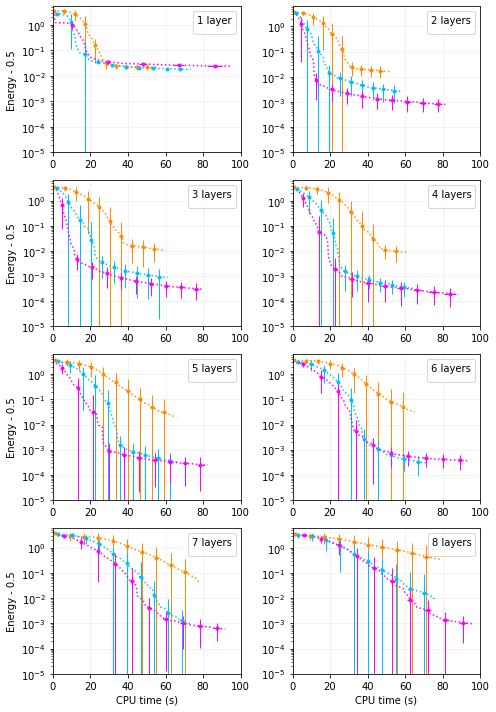

<Figure size 432x288 with 0 Axes>

In [ ]:
#multiplot
fig, axs = plt.subplots(4, 2,figsize=(7, 10))

#number of runs
runs = 30


#PLOT 1 LAYER
#opening energy files and computing mean and standard deviation
energie1 = np.loadtxt("energie_1couche_500params.txt", dtype=float, delimiter=' ')
energie2 = np.loadtxt("energie_1couche_5000params.txt", dtype=float, delimiter=' ')
energie3 = np.loadtxt("energie_1couche_30600params.txt", dtype=float, delimiter=' ')
E1_error = np.std(energie1-0.5,0)
E1_moy = np.sum(energie1-0.5,axis=0)/runs
E2_error = np.std(energie2-0.5,0)
E2_moy = np.sum(energie2-0.5,axis=0)/runs
E3_error = np.std(energie3-0.5,0)
E3_moy = np.sum(energie3-0.5,axis=0)/runs
#opening time files and computing mean and standard deviation
temps1 = np.loadtxt("temps_1couche_500params.txt", dtype=float, delimiter=' ')
temps2 = np.loadtxt("temps_1couche_5000params.txt", dtype=float, delimiter=' ')
temps3 = np.loadtxt("temps_1couche_30600params.txt", dtype=float, delimiter=' ')
temps1_moy = np.sum(temps1,0)/runs
temps1_error = np.std(temps1,axis=0)
temps2_moy = np.sum(temps2,0)/runs
temps2_error = np.std(temps2,axis=0)
temps3_moy = np.sum(temps3,0)/runs
temps3_error = np.std(temps3,axis=0)

#plot scale
axs[0, 0].set_yscale('log')
#DOTTED LINES
axs[0, 0].errorbar(temps1_moy,E1_moy,c='darkorange',linestyle="dotted")
axs[0, 0].errorbar(temps2_moy,E2_moy,c='deepskyblue',linestyle="dotted")
axs[0, 0].errorbar(temps3_moy[0:5000:1],E3_moy[0:5000:1],c='fuchsia',linestyle="dotted")
#MARKERS WITH ERROR BARS
axs[0, 0].errorbar(temps1_moy[0::1000],E1_moy[0::1000], xerr=temps1_error[0::1000], yerr = E1_error[0::1000],marker='.',c='darkorange',linestyle="None",elinewidth=1)
axs[0, 0].errorbar(temps2_moy[249::1000],E2_moy[249::1000], xerr=temps2_error[249::1000], yerr = E2_error[249::1000],marker='.',c='deepskyblue',linestyle="None",elinewidth=1)
axs[0, 0].errorbar(temps3_moy[498:5000:1000],E3_moy[498:5000:1000], xerr=temps3_error[498:5000:1000], yerr = E3_error[498:5000:1000],marker='.',c='fuchsia',linestyle="None",elinewidth=1)
axs[0, 0].set_ylabel('Energy - 0.5')
axs[0, 0].set_ylim(pow(10,-5), 0)
axs[0, 0].set_xlim(0, 100)
axs[0, 0].legend(loc='upper right',title = '1 layer')
axs[0, 0].grid(axis='both',alpha=0.2)












#PLOT 2 LAYERZ
#opening energy files and computing mean and standard deviation
energie1 = np.loadtxt("energie_2couche_500params.txt", dtype=float, delimiter=' ')
energie2 = np.loadtxt("energie_2couche_5000params.txt", dtype=float, delimiter=' ')
energie3 = np.loadtxt("energie_2couche_30600params.txt", dtype=float, delimiter=' ')
E1_error = np.std(energie1-0.5,0)
E1_moy = np.sum(energie1-0.5,axis=0)/runs
E2_error = np.std(energie2-0.5,0)
E2_moy = np.sum(energie2-0.5,axis=0)/runs
E3_error = np.std(energie3-0.5,0)
E3_moy = np.sum(energie3-0.5,axis=0)/runs
#opening time files and computing mean and standard deviation
temps1 = np.loadtxt("temps_2couche_500params.txt", dtype=float, delimiter=' ')
temps2 = np.loadtxt("temps_2couche_5000params.txt", dtype=float, delimiter=' ')
temps3 = np.loadtxt("temps_2couche_30600params.txt", dtype=float, delimiter=' ')
temps1_moy = np.sum(temps1,0)/runs
temps1_error = np.std(temps1,axis=0)
temps2_moy = np.sum(temps2,0)/runs
temps2_error = np.std(temps2,axis=0)
temps3_moy = np.sum(temps3,0)/runs
temps3_error = np.std(temps3,axis=0)

#plot scale
axs[0, 1].set_yscale('log')
#LINES
axs[0, 1].errorbar(temps1_moy,E1_moy,c='darkorange',linestyle="dotted")
axs[0, 1].errorbar(temps2_moy,E2_moy,c='deepskyblue',linestyle="dotted")
axs[0, 1].errorbar(temps3_moy,E3_moy,c='fuchsia',linestyle="dotted")
#MARKERS
axs[0, 1].errorbar(temps1_moy[0::1000],E1_moy[0::1000], xerr=temps1_error[0::1000], yerr = E1_error[0::1000],marker='.',c='darkorange',linestyle="None",elinewidth=1)
axs[0, 1].errorbar(temps2_moy[249::1000],E2_moy[249::1000], xerr=temps2_error[249::1000], yerr = E2_error[249::1000],marker='.',c='deepskyblue',linestyle="None",elinewidth=1)
axs[0, 1].errorbar(temps3_moy[498::1000],E3_moy[498::1000], xerr=temps3_error[498::1000], yerr = E3_error[498::1000],marker='.',c='fuchsia',linestyle="None",elinewidth=1)
axs[0, 1].set_ylim(pow(10,-5), 0)
axs[0, 1].set_xlim(0, 100)
axs[0, 1].legend(title = '2 layers')
axs[0, 1].grid(axis='both',alpha=0.2)











#PLOT 3 LAYERZ
#opening energy files and computing mean and standard deviation
energie1 = np.loadtxt("energie_3couche_500params.txt", dtype=float, delimiter=' ')
energie2 = np.loadtxt("energie_3couche_5000params.txt", dtype=float, delimiter=' ')
energie3 = np.loadtxt("energie_3couche_30600params.txt", dtype=float, delimiter=' ')
E1_error = np.std(energie1-0.5,0)
E1_moy = np.sum(energie1-0.5,axis=0)/runs
E2_error = np.std(energie2-0.5,0)
E2_moy = np.sum(energie2-0.5,axis=0)/runs
E3_error = np.std(energie3-0.5,0)
E3_moy = np.sum(energie3-0.5,axis=0)/runs
#opening time files and computing mean and standard deviation
temps1 = np.loadtxt("temps_3couche_500params.txt", dtype=float, delimiter=' ')
temps2 = np.loadtxt("temps_3couche_5000params.txt", dtype=float, delimiter=' ')
temps3 = np.loadtxt("temps_3couche_30600params.txt", dtype=float, delimiter=' ')
temps1_moy = np.sum(temps1,0)/runs
temps1_error = np.std(temps1,axis=0)
temps2_moy = np.sum(temps2,0)/runs
temps2_error = np.std(temps2,axis=0)
temps3_moy = np.sum(temps3,0)/runs
temps3_error = np.std(temps3,axis=0)

#plot scale
axs[1, 0].set_yscale('log')
#LINES
axs[1, 0].errorbar(temps1_moy,E1_moy,c='darkorange',linestyle="dotted")
axs[1, 0].errorbar(temps2_moy,E2_moy,c='deepskyblue',linestyle="dotted")
axs[1, 0].errorbar(temps3_moy,E3_moy,c='fuchsia',linestyle="dotted")
#MARKERS
axs[1, 0].errorbar(temps1_moy[0::1000],E1_moy[0::1000], xerr=temps1_error[0::1000], yerr = E1_error[0::1000],marker='.',c='darkorange',linestyle="None",elinewidth=1)
axs[1, 0].errorbar(temps2_moy[249::1000],E2_moy[249::1000], xerr=temps2_error[249::1000], yerr = E2_error[249::1000],marker='.',c='deepskyblue',linestyle="None",elinewidth=1)
axs[1, 0].errorbar(temps3_moy[498::1000],E3_moy[498::1000], xerr=temps3_error[498::1000], yerr = E3_error[498::1000],marker='.',c='fuchsia',linestyle="None",elinewidth=1)
axs[1, 0].set_ylabel('Energy - 0.5')
axs[1, 0].set_ylim(pow(10,-5), 0)
axs[1, 0].set_xlim(0, 100)
axs[1, 0].legend(title = '3 layers')
axs[1, 0].grid(axis='both',alpha=0.2)












#PLOT 4 LAYERS
#opening energy files and computing mean and standard deviation
energie1 = np.loadtxt("energie_4couche_500params.txt", dtype=float, delimiter=' ')
energie2 = np.loadtxt("energie_4couche_5000params.txt", dtype=float, delimiter=' ')
energie3 = np.loadtxt("energie_4couche_30600params.txt", dtype=float, delimiter=' ')
E1_error = np.std(energie1-0.5,0)
E1_moy = np.sum(energie1-0.5,axis=0)/runs
E2_error = np.std(energie2-0.5,0)
E2_moy = np.sum(energie2-0.5,axis=0)/runs
E3_error = np.std(energie3-0.5,0)
E3_moy = np.sum(energie3-0.5,axis=0)/runs
#opening time files and computing mean and standard deviation
temps1 = np.loadtxt("temps_4couche_500params.txt", dtype=float, delimiter=' ')
temps2 = np.loadtxt("temps_4couche_5000params.txt", dtype=float, delimiter=' ')
temps3 = np.loadtxt("temps_4couche_30600params.txt", dtype=float, delimiter=' ')
temps1_moy = np.sum(temps1,0)/runs
temps1_error = np.std(temps1,axis=0)
temps2_moy = np.sum(temps2,0)/runs
temps2_error = np.std(temps2,axis=0)
temps3_moy = np.sum(temps3,0)/runs
temps3_error = np.std(temps3,axis=0)

#plot scale
axs[1, 1].set_yscale('log')
#LINES
axs[1, 1].errorbar(temps1_moy,E1_moy,c='darkorange',linestyle="dotted")
axs[1, 1].errorbar(temps2_moy,E2_moy,c='deepskyblue',linestyle="dotted")
axs[1, 1].errorbar(temps3_moy,E3_moy,c='fuchsia',linestyle="dotted")
#MARKERS
axs[1, 1].errorbar(temps1_moy[0::1000],E1_moy[0::1000], xerr=temps1_error[0::1000], yerr = E1_error[0::1000],marker='.',c='darkorange',linestyle="None",elinewidth=1)
axs[1, 1].errorbar(temps2_moy[249::1000],E2_moy[249::1000], xerr=temps2_error[249::1000], yerr = E2_error[249::1000],marker='.',c='deepskyblue',linestyle="None",elinewidth=1)
axs[1, 1].errorbar(temps3_moy[498::1000],E3_moy[498::1000], xerr=temps3_error[498::1000], yerr = E3_error[498::1000],marker='.',c='fuchsia',linestyle="None",elinewidth=1)
axs[1, 1].set_ylim(pow(10,-5), 0)
axs[1, 1].set_xlim(0, 100)
axs[1, 1].legend(title = '4 layers')
axs[1, 1].grid(axis='both',alpha=0.2)












#PLOT 5 LAYERS
#opening energy files and computing mean and standard deviation
energie1 = np.loadtxt("energie_5couche_500params.txt", dtype=float, delimiter=' ')
energie2 = np.loadtxt("energie_5couche_5000params.txt", dtype=float, delimiter=' ')
energie3 = np.loadtxt("energie_5couche_30600params.txt", dtype=float, delimiter=' ')
E1_error = np.std(energie1-0.5,0)
E1_moy = np.sum(energie1-0.5,axis=0)/runs
E2_error = np.std(energie2-0.5,0)
E2_moy = np.sum(energie2-0.5,axis=0)/runs
E3_error = np.std(energie3-0.5,0)
E3_moy = np.sum(energie3-0.5,axis=0)/runs
#opening time files and computing mean and standard deviation
temps1 = np.loadtxt("temps_5couche_500params.txt", dtype=float, delimiter=' ')
temps2 = np.loadtxt("temps_5couche_5000params.txt", dtype=float, delimiter=' ')
temps3 = np.loadtxt("temps_5couche_30600params.txt", dtype=float, delimiter=' ')
temps1_moy = np.sum(temps1,0)/runs
temps1_error = np.std(temps1,axis=0)
temps2_moy = np.sum(temps2,0)/runs
temps2_error = np.std(temps2,axis=0)
temps3_moy = np.sum(temps3,0)/runs
temps3_error = np.std(temps3,axis=0)

#plot scale
axs[2, 0].set_yscale('log')
#LINES
axs[2, 0].errorbar(temps1_moy,E1_moy,c='darkorange',linestyle="dotted")
axs[2, 0].errorbar(temps2_moy,E2_moy,c='deepskyblue',linestyle="dotted")
axs[2, 0].errorbar(temps3_moy,E3_moy,c='fuchsia',linestyle="dotted")
#MARKERS
axs[2, 0].errorbar(temps1_moy[0::1000],E1_moy[0::1000], xerr=temps1_error[0::1000], yerr = E1_error[0::1000],marker='.',c='darkorange',linestyle="None",elinewidth=1)
axs[2, 0].errorbar(temps2_moy[249::1000],E2_moy[249::1000], xerr=temps2_error[249::1000], yerr = E2_error[249::1000],marker='.',c='deepskyblue',linestyle="None",elinewidth=1)
axs[2, 0].errorbar(temps3_moy[498::1000],E3_moy[498::1000], xerr=temps3_error[498::1000], yerr = E3_error[498::1000],marker='.',c='fuchsia',linestyle="None",elinewidth=1)
axs[2, 0].set_ylabel('Energy - 0.5')
axs[2, 0].set_ylim(pow(10,-5), 0)
axs[2, 0].set_xlim(0, 100)
axs[2, 0].legend(title = '5 layers',loc='upper right')
axs[2, 0].grid(axis='both',alpha=0.2)













#PLOT 6 LAYERS
#opening energy files and computing mean and standard deviation
energie1 = np.loadtxt("energie_6couche_500params.txt", dtype=float, delimiter=' ')
energie2 = np.loadtxt("energie_6couche_5000params.txt", dtype=float, delimiter=' ')
energie3 = np.loadtxt("energie_6couche_30600params.txt", dtype=float, delimiter=' ')
E1_error = np.std(energie1-0.5,0)
E1_moy = np.sum(energie1-0.5,axis=0)/runs
E2_error = np.std(energie2-0.5,0)
E2_moy = np.sum(energie2-0.5,axis=0)/runs
E3_error = np.std(energie3-0.5,0)
E3_moy = np.sum(energie3-0.5,axis=0)/runs
#opening time files and computing mean and standard deviation
temps1 = np.loadtxt("temps_6couche_500params.txt", dtype=float, delimiter=' ')
temps2 = np.loadtxt("temps_6couche_5000params.txt", dtype=float, delimiter=' ')
temps3 = np.loadtxt("temps_6couche_30600params.txt", dtype=float, delimiter=' ')
temps1_moy = np.sum(temps1,0)/runs
temps1_error = np.std(temps1,axis=0)
temps2_moy = np.sum(temps2,0)/runs
temps2_error = np.std(temps2,axis=0)
temps3_moy = np.sum(temps3,0)/runs
temps3_error = np.std(temps3,axis=0)

#plot scale
axs[2, 1].set_yscale('log')
#LINES
axs[2, 1].errorbar(temps1_moy,E1_moy,c='darkorange',linestyle="dotted")
axs[2, 1].errorbar(temps2_moy,E2_moy,c='deepskyblue',linestyle="dotted")
axs[2, 1].errorbar(temps3_moy,E3_moy,c='fuchsia',linestyle="dotted")
#MARKERS
axs[2, 1].errorbar(temps1_moy[0::1000],E1_moy[0::1000], xerr=temps1_error[0::1000], yerr = E1_error[0::1000],marker='.',c='darkorange',linestyle="None",elinewidth=1)
axs[2, 1].errorbar(temps2_moy[249::1000],E2_moy[249::1000], xerr=temps2_error[249::1000], yerr = E2_error[249::1000],marker='.',c='deepskyblue',linestyle="None",elinewidth=1)
axs[2, 1].errorbar(temps3_moy[498::1000],E3_moy[498::1000], xerr=temps3_error[498::1000], yerr = E3_error[498::1000],marker='.',c='fuchsia',linestyle="None",elinewidth=1)
axs[2, 1].set_ylim(pow(10,-5), 0)
axs[2, 1].set_xlim(0, 100)
axs[2, 1].legend(title = '6 layers',loc='upper right')
axs[2, 1].grid(axis='both',alpha=0.2)














#plot 7 couche
#opening energy files and computing mean and standard deviation
energie1 = np.loadtxt("energie_7couche_500params.txt", dtype=float, delimiter=' ')
energie2 = np.loadtxt("energie_7couche_5000params.txt", dtype=float, delimiter=' ')
energie3 = np.loadtxt("energie_7couche_30600params.txt", dtype=float, delimiter=' ')


E1_error = np.std(energie1-0.5,0)
E1_moy = np.sum(energie1-0.5,axis=0)/runs

E2_error = np.std(energie2-0.5,0)
E2_moy = np.sum(energie2-0.5,axis=0)/runs

E3_error = np.std(energie3-0.5,0)
E3_moy = np.sum(energie3-0.5,axis=0)/runs

#opening time files and computing mean and standard deviation
temps1 = np.loadtxt("temps_7couche_500params.txt", dtype=float, delimiter=' ')
temps2 = np.loadtxt("temps_7couche_5000params.txt", dtype=float, delimiter=' ')
temps3 = np.loadtxt("temps_7couche_30600params.txt", dtype=float, delimiter=' ')

temps1_moy = np.sum(temps1,0)/runs
temps1_error = np.std(temps1,axis=0)

temps2_moy = np.sum(temps2,0)/runs
temps2_error = np.std(temps2,axis=0)

temps3_moy = np.sum(temps3,0)/runs
temps3_error = np.std(temps3,axis=0)

#plot scale
axs[3, 0].set_yscale('log')
#LINES
axs[3, 0].errorbar(temps1_moy,E1_moy,c='darkorange',linestyle="dotted")
axs[3, 0].errorbar(temps2_moy,E2_moy,c='deepskyblue',linestyle="dotted")
axs[3, 0].errorbar(temps3_moy,E3_moy,c='fuchsia',linestyle="dotted")
#MARKERS
axs[3, 0].errorbar(temps1_moy[0::1000],E1_moy[0::1000], xerr=temps1_error[0::1000], yerr = E1_error[0::1000],marker='.',c='darkorange',linestyle="None",elinewidth=1)
axs[3, 0].errorbar(temps2_moy[249::1000],E2_moy[249::1000], xerr=temps2_error[249::1000], yerr = E2_error[249::1000],marker='.',c='deepskyblue',linestyle="None",elinewidth=1)
axs[3, 0].errorbar(temps3_moy[498::1000],E3_moy[498::1000], xerr=temps3_error[498::1000], yerr = E3_error[498::1000],marker='.',c='fuchsia',linestyle="None",elinewidth=1)
axs[3, 0].set_ylabel('Energy - 0.5')
axs[3, 0].set_xlabel('CPU time (s)')
axs[3, 0].set_ylim(pow(10,-5), 0)
axs[3, 0].set_xlim(0, 100)
axs[3, 0].legend(title = '7 layers')
axs[3, 0].grid(axis='both',alpha=0.2)









#plot 8 couche
#opening energy files and computing mean and standard deviation
energie1 = np.loadtxt("energie_8couche_500params.txt", dtype=float, delimiter=' ')
energie2 = np.loadtxt("energie_8couche_5000params.txt", dtype=float, delimiter=' ')
energie3 = np.loadtxt("energie_8couche_30600params.txt", dtype=float, delimiter=' ')
E1_error = np.std(energie1-0.5,0)
E1_moy = np.sum(energie1-0.5,axis=0)/runs
E2_error = np.std(energie2-0.5,0)
E2_moy = np.sum(energie2-0.5,axis=0)/runs
E3_error = np.std(energie3-0.5,0)
E3_moy = np.sum(energie3-0.5,axis=0)/runs
#opening time files and computing mean and standard deviation
temps1 = np.loadtxt("temps_8couche_500params.txt", dtype=float, delimiter=' ')
temps2 = np.loadtxt("temps_8couche_5000params.txt", dtype=float, delimiter=' ')
temps3 = np.loadtxt("temps_8couche_30600params.txt", dtype=float, delimiter=' ')
temps1_moy = np.sum(temps1,0)/runs
temps1_error = np.std(temps1,axis=0)
temps2_moy = np.sum(temps2,0)/runs
temps2_error = np.std(temps2,axis=0)
temps3_moy = np.sum(temps3,0)/runs
temps3_error = np.std(temps3,axis=0)

#plot scale
axs[3, 1].set_yscale('log')
#LINES
axs[3, 1].errorbar(temps1_moy,E1_moy,c='darkorange',linestyle="dotted")
axs[3, 1].errorbar(temps2_moy,E2_moy,c='deepskyblue',linestyle="dotted")
axs[3, 1].errorbar(temps3_moy,E3_moy,c='fuchsia',linestyle="dotted")
#MARKERS
axs[3, 1].errorbar(temps1_moy[0::1000],E1_moy[0::1000], xerr=temps1_error[0::1000], yerr = E1_error[0::1000],marker='.',c='darkorange',linestyle="None",elinewidth=1)
axs[3, 1].errorbar(temps2_moy[249::1000],E2_moy[249::1000], xerr=temps2_error[249::1000], yerr = E2_error[249::1000],marker='.',c='deepskyblue',linestyle="None",elinewidth=1)
axs[3, 1].errorbar(temps3_moy[498::1000],E3_moy[498::1000], xerr=temps3_error[498::1000], yerr = E3_error[498::1000],marker='.',c='fuchsia',linestyle="None",elinewidth=1)
axs[3, 1].set_xlabel('CPU time (s)')
axs[3, 1].set_ylim(pow(10,-5), 0)
axs[3, 1].set_xlim(0, 100)
axs[3, 1].legend(title = '8 layers')
axs[3, 1].grid(axis='both',alpha=0.2)







#############
# SHOWING AND SAVING PLOTS
#############
plt.tight_layout()
plt.savefig('precision_time_multiplot.pdf')
plt.show()
plt.clf()